In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, concatenate, Masking, LSTM, TimeDistributed, Lambda, Reshape, Multiply, BatchNormalization, Bidirectional
from tensorflow.keras import regularizers 
from tensorflow.keras import initializers
import h5py 
import os 
from clr_callback import *
from tensorflow.keras.optimizers import * 
# import keras_one_cycle_clr as ktool

os.environ["CUDA_VISIBLE_DEVICES"]="0"

%matplotlib inline 

dataset = h5py.File('./../../../../../data/hongtao/both-5-8-2020.h5','r')

X_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi']
Y_keys = ['th_pt', 'th_eta','th_phi','th_m', 'wh_pt', 'wh_eta', 'wh_phi', 'wh_m', 'tl_pt', 'tl_eta', 'tl_phi', 'tl_m', 'wl_pt', 'wl_eta', 'wl_phi', 'wl_m']
phi_keys = list(filter(lambda a: 'phi' in a, dataset.keys()))
eta_keys = list(filter(lambda a: 'eta' in a, dataset.keys()))
pt_keys =  list(filter(lambda a: 'pt' in a, dataset.keys()))
m_keys = list(filter(lambda a: 'm' in a, dataset.keys()))
DL1r_keys = list(filter(lambda a: 'DL1r' in a, dataset.keys()))

Y_length = len(Y_keys)
X_length = len(X_keys)
crop0 =  1000000

In [2]:
import scale_variables
import shape_timesteps

# How to scale each input/output
def get_methods(keys):
    types = {'pt':'cart_pt', 'eta':'meanmax', 'phi':'sincos', 'DL1r':'DL1r', 'm':'meanmax', 'met':'meanmax'}
    var_types = [key.split('_')[1] for key in keys]
    methods = [types[var] for var in var_types]
    return methods

X_methods = get_methods(X_keys)
Y_methods = get_methods(Y_keys)

Scaler = scale_variables.Scale_variables()
(X_total, X_maxmean), X_names = Scaler.scale_arrays(X_keys, X_methods, True)
(Y_total, Y_maxmean), Y_names = Scaler.scale_arrays(Y_keys, Y_methods, True)

error = Scaler.test_inverse(Y_keys, Y_methods, True)
print('Max scaling error: {}'.format(error))

Max scaling error: 4.547473508864641e-13


In [3]:
# Create X and test array
split = int(np.floor(0.9*crop0)) # 80/20 split 

trainY, testY = Y_total[0:split,:], Y_total[split:,:]

timestep_builder = shape_timesteps.Shape_timesteps()
totalX_jets, totalX_other = timestep_builder.reshape_X(X_total, X_names, False,True)
    
    


In [4]:
DL1r = totalX_jets[:,:,1]
argDL1r = np.argsort(DL1r,axis=-1)
argDL1r = argDL1r.reshape((argDL1r.shape[0], -1, 1))
jets_byDL1r = np.take_along_axis(totalX_jets, argDL1r, axis=1)

totalX_jets = jets_byDL1r

In [5]:
# j1 = jets_byDL1r[:,0,:]
# bh = 
# print(j1.shape)

In [6]:
# def random_choice_noreplace(m,n, axis=-1):
#     # m, n are the number of rows, cols of output
#     return np.array(np.random.rand(m,n).argsort(axis=axis))

# def random_shuffle_jets(jets):
#     m,n = jets.shape[0], jets.shape[1]
#     idx = random_choice_noreplace(m,n,axis=1).reshape((m,n,1))
#     return np.take_along_axis(jets,idx,axis=1)

# totalX_jets = random_shuffle_jets(totalX_jets)

In [7]:
trainX_jets, testX_jets = totalX_jets[0:split,:,:], totalX_jets[split:,:,:]
trainX_other, testX_other = totalX_other[0:split,:], totalX_other[split:,:]

# Save some memory 
del totalX_jets
del totalX_other 

print(trainX_jets.shape, trainX_other.shape, trainY.shape)
print(testX_jets.shape, testX_other.shape, testY.shape)

(900000, 6, 6) (900000, 7) (900000, 20)
(100000, 6, 6) (100000, 7) (100000, 20)


In [8]:
# Histograms of total  Y variables 
show = False

other_bins = np.linspace(-1, 1, 40)
phi_bins = np.linspace(-1, 1, 40)
pt_bins = np.linspace(-1, 1, 40)
Y_bins = [phi_bins if 'phi' in name else pt_bins if 'pt' in name else other_bins for name in Y_names]

if show:
    plt.figure(figsize=(6,6*trainY.shape[1]))
    for i in range(0, trainY.shape[1]):
        plt.subplot(trainY.shape[1], 1, i+1)
        bins = Y_bins[i]
        plt.hist(Y_total[:,i], bins, histtype='step')
        plt.xlabel(Y_names[i])
        plt.ylabel('Frequency')

In [9]:
# Histograms of X variables (without the mask)
show = False

if show:
    plt.figure(figsize=(6,6*X_total.shape[1]))
    for i in range(0, X_total.shape[1]):
        plt.subplot(X_total.shape[1], 1, i+1)
        plt.hist(X_total[:,i], 40, histtype='step')
        plt.xlabel(X_names[i])
        plt.ylabel('Frequency')

 

In [10]:
# Build model

def build_model():
    jet_input = Input(shape=(trainX_jets.shape[1], trainX_jets.shape[2]))
    Mask = Masking(-2)(jet_input)
    Maskshape = Reshape((trainX_jets.shape[1], trainX_jets.shape[2]))(Mask)
    other_input = Input(shape=(trainX_other.shape[1]))
    flat_jets =  Flatten()(jet_input)
    concat0 = concatenate([other_input, flat_jets])
    PreDense1 = Dense(256, activation='relu')(concat0)
    PreDense2 = Dense(256, activation='relu')(PreDense1)
    PreDense3 = Dense(trainX_jets.shape[1], activation='sigmoid')(PreDense2)
    Shape_Dot = Reshape((-1,1))(PreDense3)
    
    TDDense11 = TimeDistributed(Dense(128, activation='relu'))(Maskshape)
    TDDense12 = TimeDistributed(Dense(64, activation='relu'))(TDDense11)
    Dot_jets = Multiply()([Shape_Dot, TDDense12])
    TDDense13 = TimeDistributed(Dense(128, activation='relu'))(Dot_jets)
    TDDense14= TimeDistributed(Dense(128, activation='relu'))(TDDense13)
    flat_right = Flatten()(TDDense14)
    
    Dense21 = Dense(128, activation='relu')(other_input)
    Dense22 = Dense(128, activation='relu')(Dense21)
    flat_other = Flatten()(Dense22)
    
    concat = concatenate([flat_other, flat_right])
    
    ldense1 = Dense(256, activation='relu')(concat)
    ldense2 = Dense(128, activation='relu')(ldense1)
    loutput = Dense(len(Y_names)//2)(ldense2)
    
    hconcat = concatenate([loutput, concat])
    hdense1 = Dense(256, activation='relu')(hconcat)
    hdense2 = Dense(128, activation='relu')(hdense1)
    houtput = Dense(len(Y_names)//2)(hdense2)
    
    output = concatenate([houtput, loutput])
    
    model = keras.models.Model(inputs=[jet_input, other_input], outputs=output)
    
    def loss_fc(true, pred):
        return K.mean(K.square(true-pred)*(1+3*K.square(K.abs(true))))
    # lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=5000,decay_rate=0.6)
    lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=1e-3, decay_steps=10000,end_learning_rate=5e-5,power=0.25)
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
    return model 

# model = keras.models.load_model('Jet_Reweight_cartpt.keras')
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 6)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 36)           0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 43)           0           input_2[0][0]                    
                                                                 flatten[0][0]                

In [11]:
# Fit model

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
clr_triangular = CyclicLR(base_lr=1e-5, max_lr=1e-4, step_size=5000, mode='exp_range',gamma=0.9999)
# class_weight = {0:2, 1:1, 2:1, 3:1, 4:1, 5:2, 6:1, 7:1, 8:1, 9:1, 10:2, 11:1, 12:1, 13:1, 14:1, 15:2, 16:1, 17:1, 18:1, 19:1}


Epochs= 256

# del X_total
# del Y_total
# def loss(true, pred):
#     return K.mean(K.square(true-pred)*(1+K.square(true)))



history = model.fit([trainX_jets, trainX_other], trainY, verbose=1, epochs=Epochs,
                   validation_data=([testX_jets, testX_other], testY), shuffle=True, callbacks=[early_stop],
                    batch_size=1000)


Train on 900000 samples, validate on 100000 samples
Epoch 1/256
900000/900000 [==============================] - 8s 9us/sample - loss: 0.0043 - mse: 0.0043 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 2/256
900000/900000 [==============================] - 7s 7us/sample - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 3/256
900000/900000 [==============================] - 7s 7us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 4/256
900000/900000 [==============================] - 7s 7us/sample - loss: 0.0035 - mse: 0.0035 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 5/256
900000/900000 [==============================] - 7s 7us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 6/256
900000/900000 [==============================] - 7s 7us/sample - loss: 0.0034 - mse: 0.0034 - val_loss: 0.0034 - val_mse: 0.0034
Epoch 7/256
900000/900000 [==============================] - 7s 7us/sample - loss: 0.0033 - mse: 0.003

In [12]:
# plt.xlabel('Training Iterations')
# plt.ylabel('Learning Rate')
# plt.title("CLR - 'triangular' Policy")
# plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

Text(0.5, 1.0, 'MSE loss')

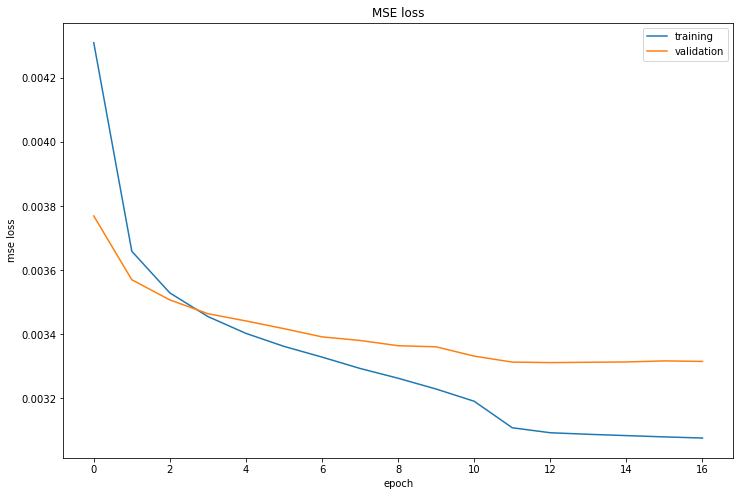

In [13]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [14]:
predictions_unscaled = model.predict([testX_jets, testX_other])
true_unscaled = testY 

total_predictions = model.predict([np.append(trainX_jets,testX_jets,axis=0), np.append(trainX_other,testX_other,axis=0)])
(Y_total, TO_maxmean0), _ = Scaler.scale_arrays(Y_keys, Y_methods, True)

predictions_origscale = Scaler.invscale_arrays(Y_keys, total_predictions, _, Y_methods, TO_maxmean0)[split:,:]
true_origscale = Scaler.invscale_arrays(Y_keys, Y_total, _, Y_methods, TO_maxmean0)[split:,:]

del Y_total
del TO_maxmean0
del _
del total_predictions

In [15]:
# np.save('true', predictions_origscale)
# np.save('pred', true_origscale)

# Training scale plots 

In [16]:
import analysis

Analysis = analysis.Analysis 
Analysis.display_errors(predictions_unscaled, true_unscaled, Y_names, False)

total MSE: 0.0033156583373465886
 
th_ptbox MSE :  0.0017612588
th_px MSE :  0.0026503631
th_py MSE :  0.0027745351
th_eta MSE :  0.0073310941
th_m MSE :  0.0042469971
wh_ptbox MSE :  0.0019059518
wh_px MSE :  0.0020846385
wh_py MSE :  0.0029017115
wh_eta MSE :  0.0098870378
wh_m MSE :  0.0034807449
tl_ptbox MSE :  0.0015773427
tl_px MSE :  0.0021002306
tl_py MSE :  0.0017899472
tl_eta MSE :  0.0051664222
tl_m MSE :  0.0047252383
wl_ptbox MSE :  0.0020617245
wl_px MSE :  0.0013203478
wl_py MSE :  0.0017331651
wl_eta MSE :  0.0036215416
wl_m MSE :  0.0031928739


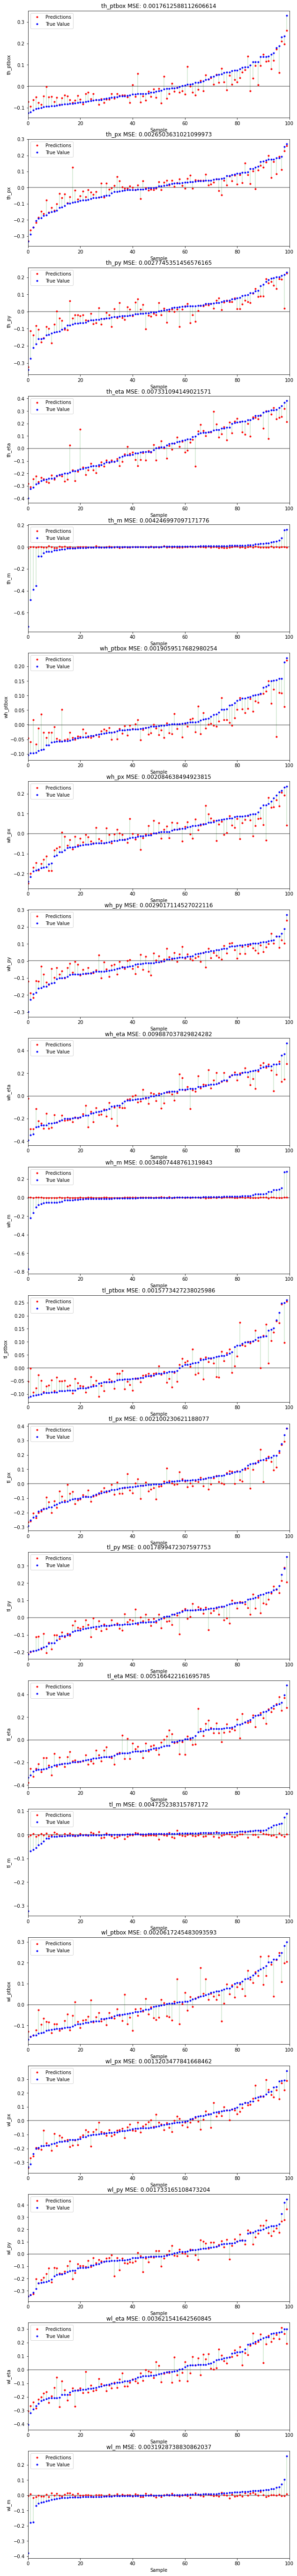

In [17]:
Analysis.predictions_vs_sample(predictions_unscaled, true_unscaled, Y_names, False)

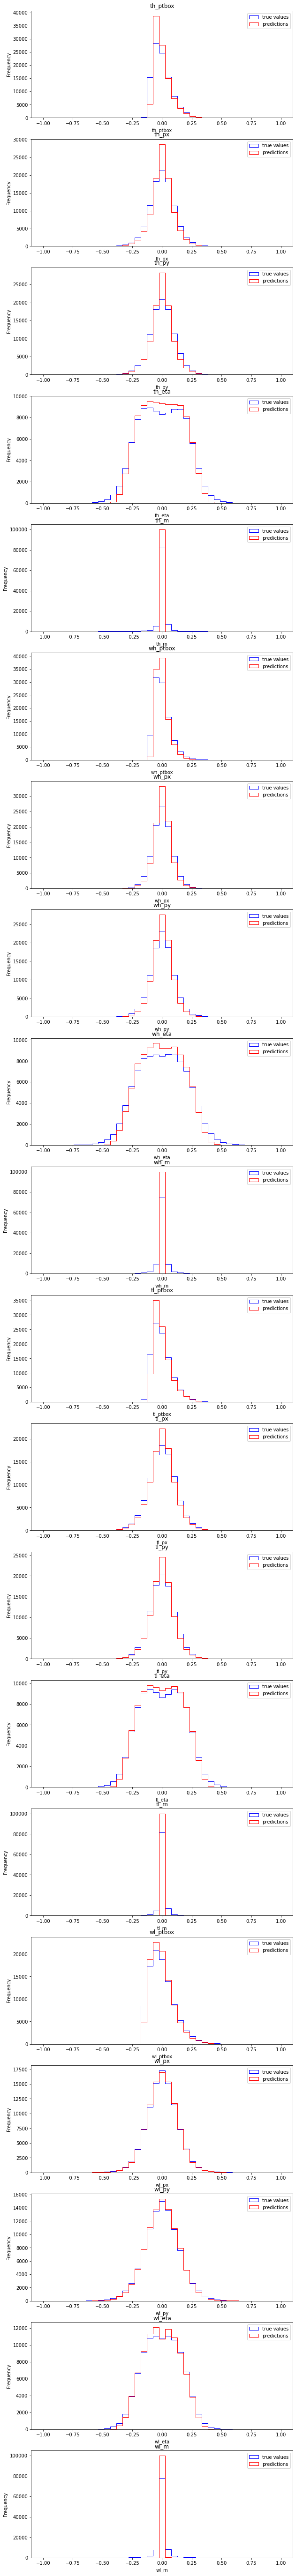

In [18]:
Analysis.variable_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

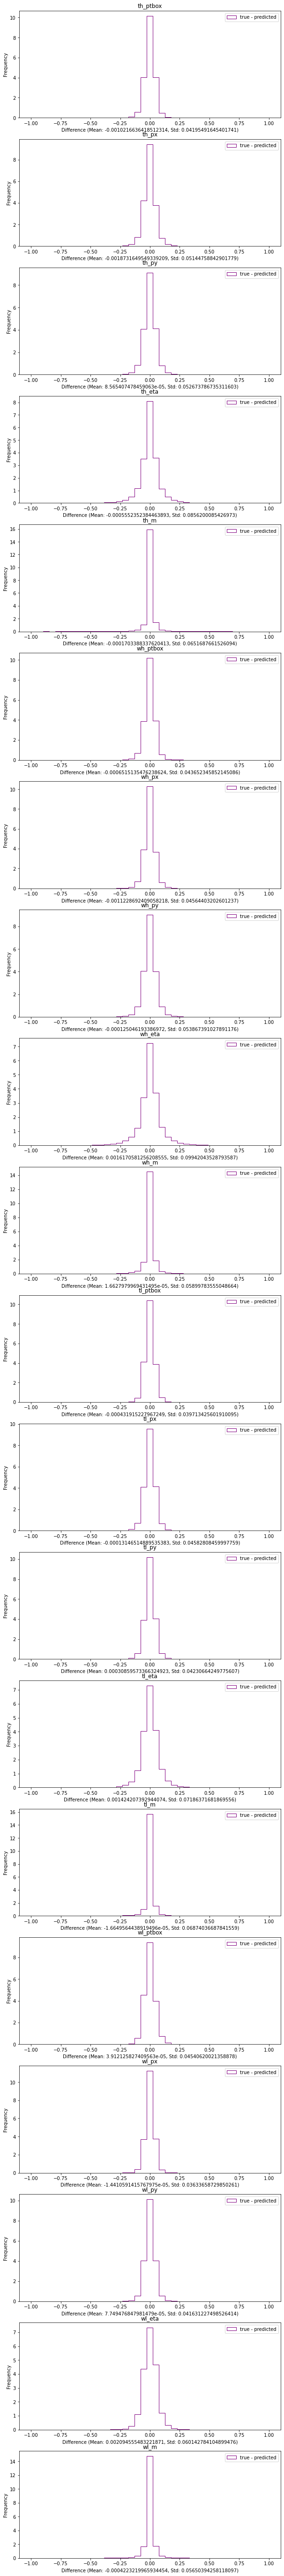

In [19]:
Analysis.difference_histogram(predictions_unscaled, true_unscaled, Y_names, False, Y_bins)

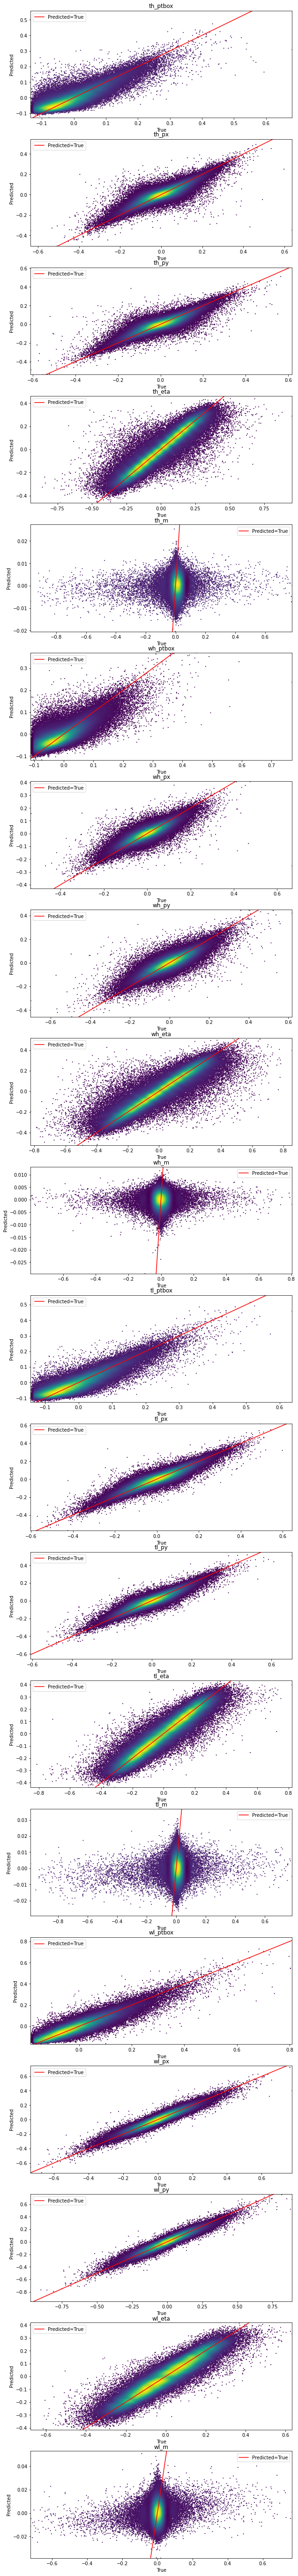

In [20]:
Analysis.predicted_vs_true(predictions_unscaled, true_unscaled, Y_names, False)

 # Original scale plots

In [21]:
Analysis.display_errors(predictions_origscale, true_origscale, Y_keys, True)

total MSE: 315.4332833394257
 
th_pt MSE :  1607.2831237435
th_eta MSE :  0.5087138292
th_phi MSE :  0.8119663278
th_m MSE :  35.3514267520
wh_pt MSE :  1402.5473100326
wh_eta MSE :  0.4889173972
wh_phi MSE :  0.7767155191
wh_m MSE :  28.1724991448
tl_pt MSE :  1299.3470981860
tl_eta MSE :  0.4062207016
tl_phi MSE :  0.5386490370
tl_m MSE :  39.2510160465
wl_pt MSE :  589.1696824079
wl_eta MSE :  0.3001619810
wl_phi MSE :  0.1942584538
wl_m MSE :  34.9385449090


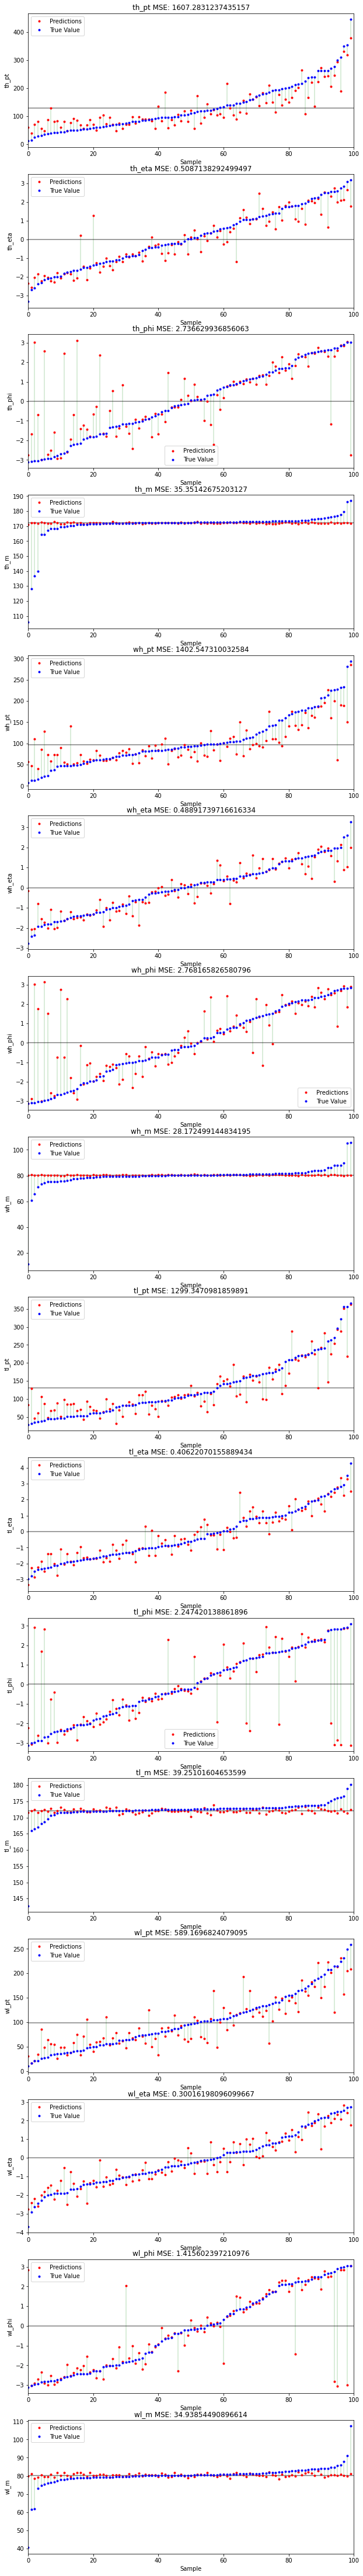

In [22]:
Analysis.predictions_vs_sample(predictions_origscale, true_origscale, Y_keys, True)

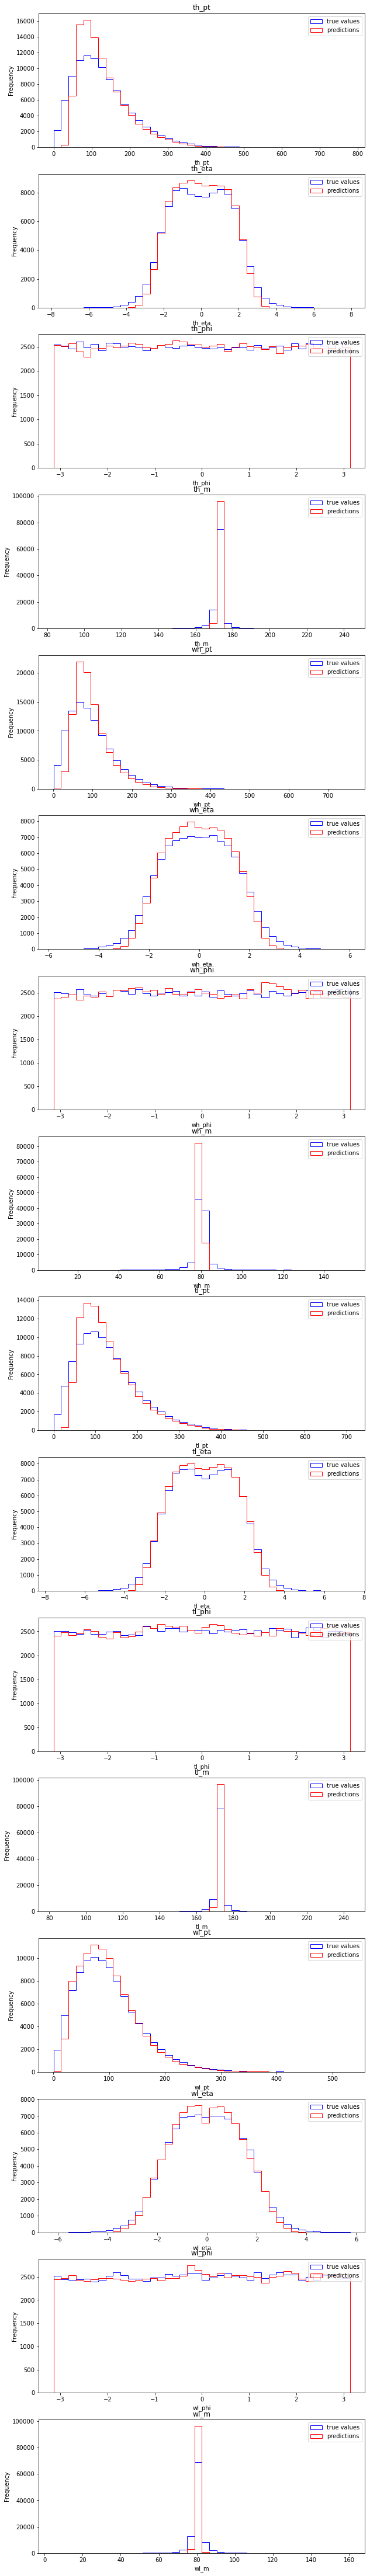

In [23]:
Analysis.variable_histogram(predictions_origscale, true_origscale, Y_keys, True, [None for name in Y_names])

In [ ]:
Analysis.predicted_vs_true(predictions_origscale, true_origscale, Y_keys, True)

# Observables

In [ ]:
import observables 
import importlib
importlib.reload(observables)
truths = observables.fill_observables(true_origscale, True, Y_keys)
preds = observables.fill_observables(predictions_origscale, False, Y_keys)

# top_dphi=np.abs(th_phi-tl_phi)
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_dphi'], preds['top_dphi'])

In [ ]:
# top_m0= th_m**2-th_p**2 + tl_m**2-tl_p**2
plt.figure(figsize=(12,6))
observables.plot_hist(truths['top_m0'],preds['top_m0'])

In [ ]:
# eta_cm=0.5*(th_eta-tl_eta), eta_boost=0.5*(th_eta+tl_eta)
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['eta_cm'], preds['eta_cm'])
plt.subplot(212)
observables.plot_hist(truths['eta_boost'], preds['eta_boost'])


In [ ]:
# th_Pout=dot(th_P, cross(tl_P,ez)/norm(tl_P,ez)), tl_Pout=dot(tl_P, cross(th_P,ez)/norm(th_P,ez))
plt.figure(figsize=(12,12))
plt.subplot(211)
observables.plot_hist(truths['th_Pout'], preds['th_Pout'])
plt.subplot(212)
observables.plot_hist(truths['tl_Pout'], preds['tl_Pout'])


In [ ]:
# pt_tot = th_pt+tl_pt
plt.figure(figsize=(12,6))
observables.plot_hist(truths['pt_tot'],preds['pt_tot'])

In [ ]:
# model.save('Jet_Reweight_cartpt.keras')

In [ ]:
np.save('aug_9/Jet_Reweight_cartpt_pred', predictions_origscale)
np.save('aug_9/Jet_Reweight_cartpt_true', true_origscale)
truth_observables = [truths[list(truths.keys())[i]].value for i in range(len(list(truths.keys())))]
pred_observables = [preds[list(preds.keys())[i]].value for i in range(len(list(preds.keys())))]
truth_observables = np.stack(truth_observables, axis=1)
truth_observables = truth_observables.reshape((truth_observables.shape[0], -1))
pred_observables = np.stack(pred_observables, axis=1)
pred_observables = pred_observables.reshape((pred_observables.shape[0], -1))

np.save('aug_9/Jet_Reweight_cartpt_pred_observables', pred_observables)
np.save('aug_9/Jet_Reweight_cartpt_true_observables', truth_observables)
print(list(preds.keys()))